# Chapter 4 - Linear Regression

## 4.1 Gamma Distribution Characteristics 

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
plt.rcParams['figure.figsize']=(15,10)

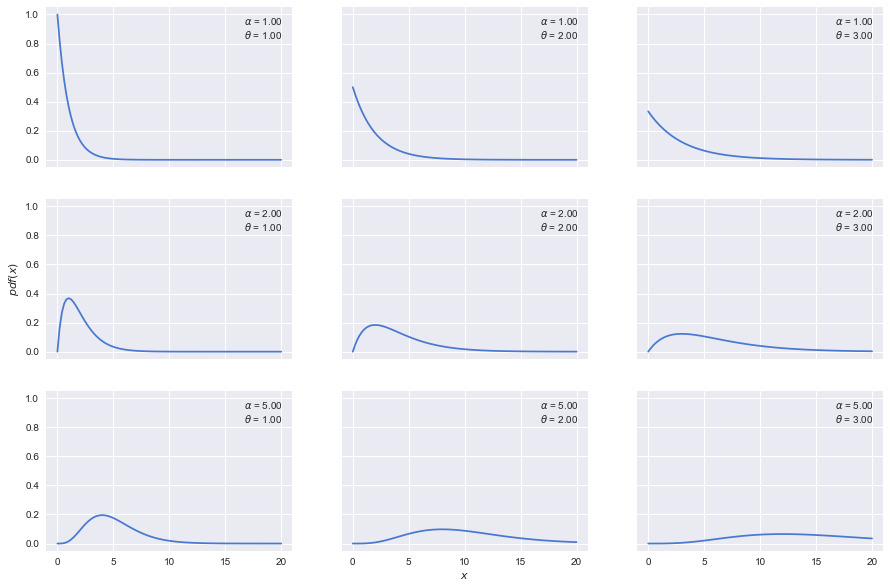

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')

## Generate data

In [3]:
np.random.seed(1)
N = 100
# y-axis intercept
alfa_real = 2.5
# slope
beta_real = 0.9

eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


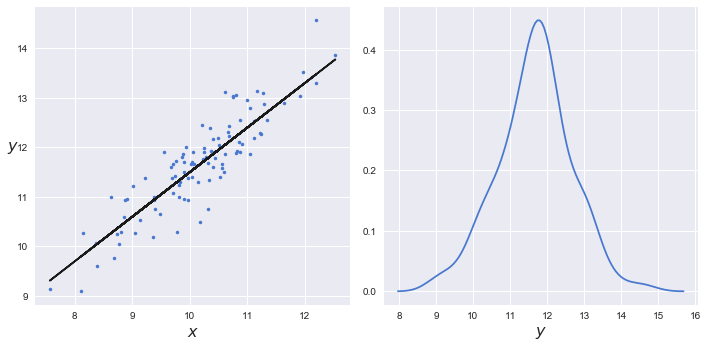

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

## Generate probabilistic regression

In [5]:
with pm.Model() as model:
    # y_intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    # slope
    beta = pm.Normal('beta', mu=0, sd=1)
    # gaussian standard deviation
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # this variable is fully determined by it's arguments and
    # is saved in the trace.
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)
    

Optimization terminated successfully.
         Current function value: 67.459650
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5187.09it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002388DE61860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238900D9160>]], dtype=object)

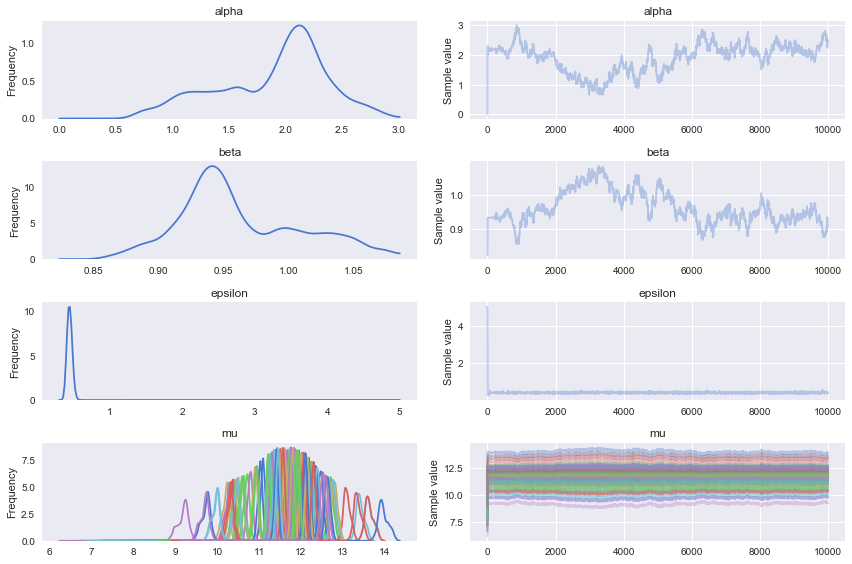

In [6]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023894289358>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x0000023893F600F0>]], dtype=object)

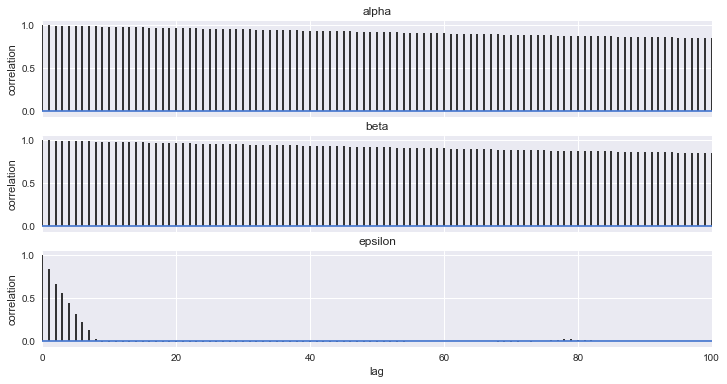

In [7]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)

# Linear Models and High Autocorrelation

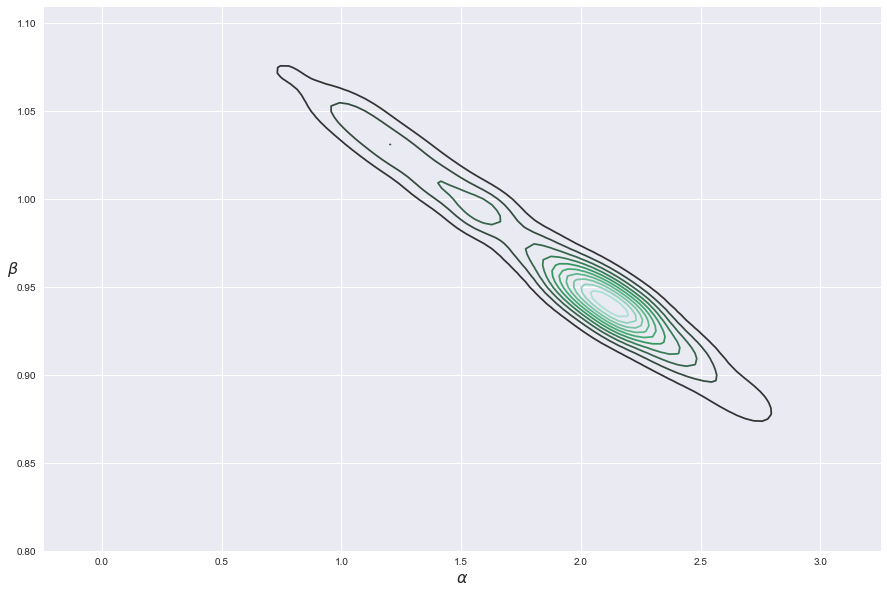

In [8]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

In [9]:
# standardize the data
from sklearn.preprocessing import StandardScaler
x_stdsc = StandardScaler()
x_scaled = x_stdsc.fit_transform(x)
y_stdsc = StandardScaler()
y_scaled = y_stdsc.fit_transform(y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

In [10]:
with pm.Model() as std_model:
    # y_intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    # slope
    beta = pm.Normal('beta', mu=0, sd=1)
    # gaussian standard deviation
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # this variable is fully determined by it's arguments and
    # is saved in the trace.
    mu = pm.Deterministic('mu', alpha + beta * x_scaled)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_scaled)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)

Optimization terminated successfully.
         Current function value: 69.066853
         Iterations: 10
         Function evaluations: 17
         Gradient evaluations: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5094.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023894646358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023896321C50>]], dtype=object)

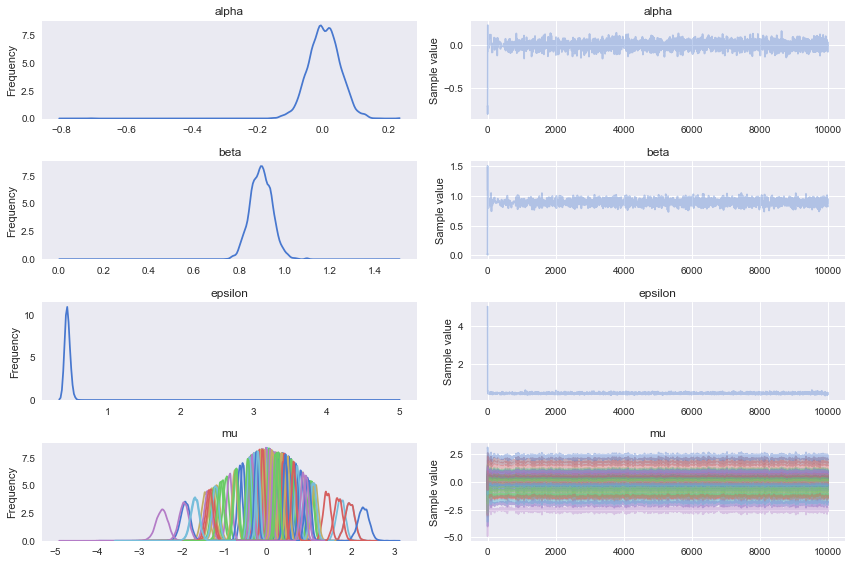

In [11]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238947DD550>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x00000238912DA240>]], dtype=object)

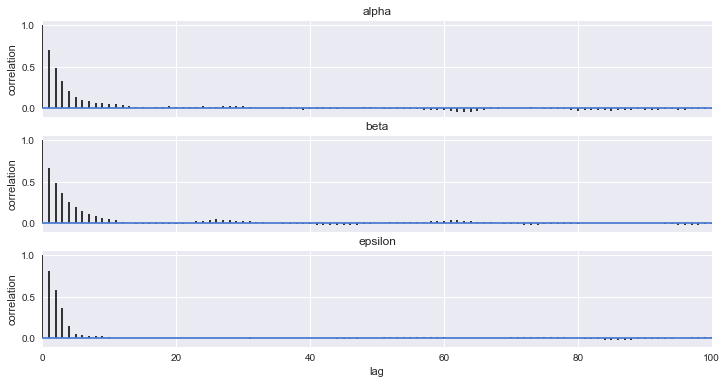

In [12]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)

(0.7, 1.1)

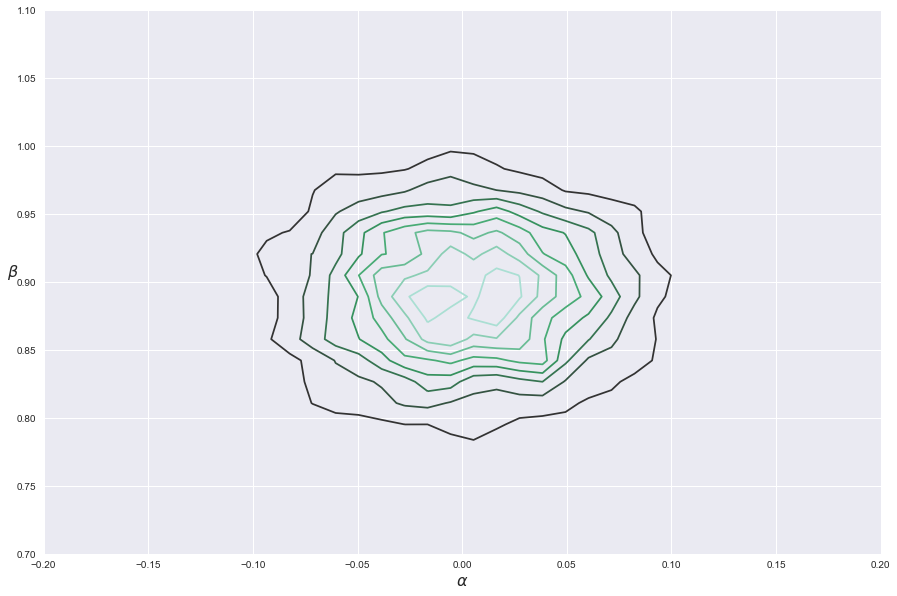

In [13]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.xlim((-0.2,0.2))
plt.ylim((0.7,1.1))

In [14]:
pm.df_summary(trace, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.10e-03,0.05,1.01e-03,-0.09,0.09
beta,8.93e-01,0.05,1.14e-03,0.80,0.98
epsilon,4.61e-01,0.10,2.33e-03,0.40,0.53


## Plotting the standardized posterior

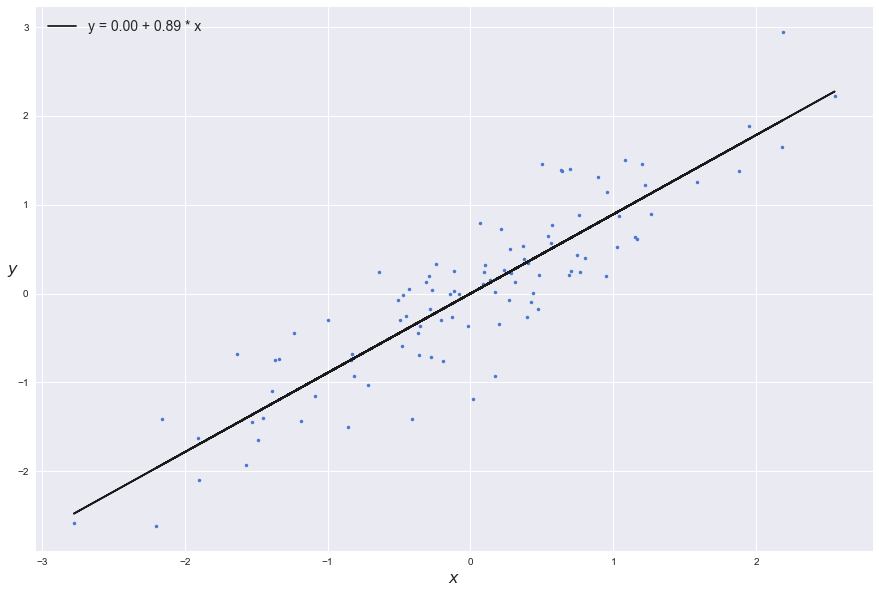

In [15]:
plt.plot(x_scaled, y_scaled, 'b.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x_scaled, alpha_m + beta_m * x_scaled, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

## Plotting the inverse standardized posterio - reverted back to original values

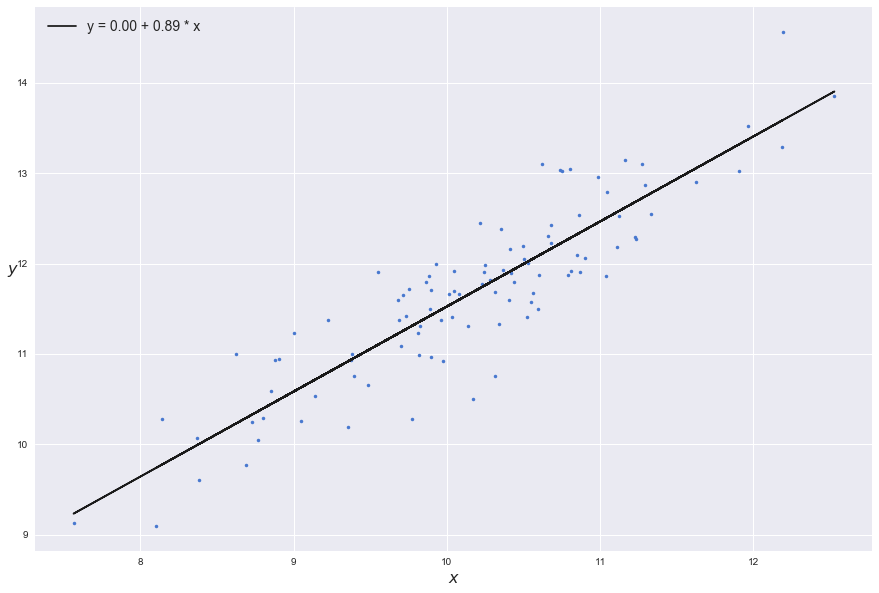

In [16]:
plt.plot(x, y, 'b.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x, y_stdsc.inverse_transform(alpha_m + beta_m * x_scaled), c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

# Changing Sampling Method

In [17]:
with pm.Model() as model_n:
    # y_intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    # slope
    beta = pm.Normal('beta', mu=0, sd=1)
    # gaussian standard deviation
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # this variable is fully determined by it's arguments and
    # is saved in the trace.
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 67.459650
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 100.74it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002389BCBDE10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002389BFFEDA0>]], dtype=object)

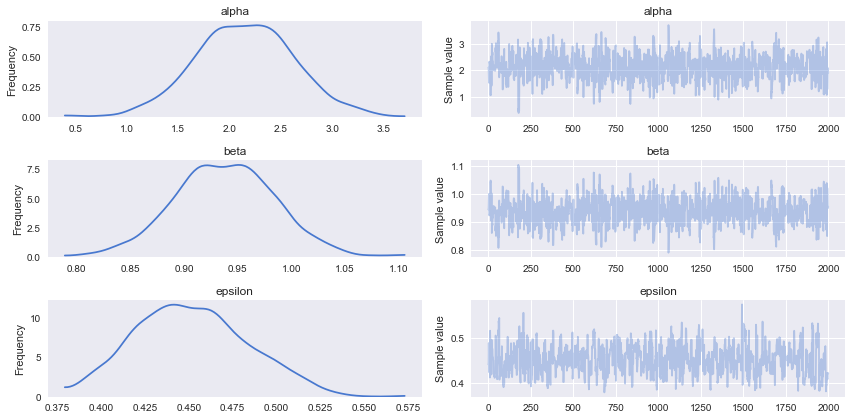

In [18]:
pm.traceplot(trace_n, varnames)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002389B42AB70>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x0000023899E7E4E0>]], dtype=object)

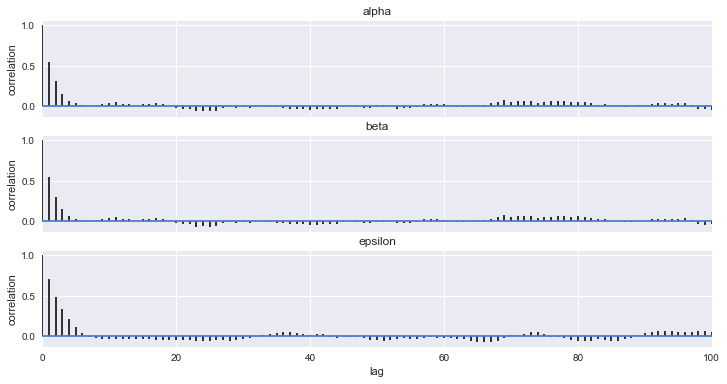

In [19]:
pm.autocorrplot(trace_n, varnames)

In [20]:
pm.df_summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.14,0.49,1.90e-02,1.26,3.18
beta,0.94,0.05,1.86e-03,0.84,1.03
epsilon,0.45,0.03,1.38e-03,0.39,0.51


## Posterior Predictive Checks

In [21]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.81it/s]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2641: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


(0, 0.6)

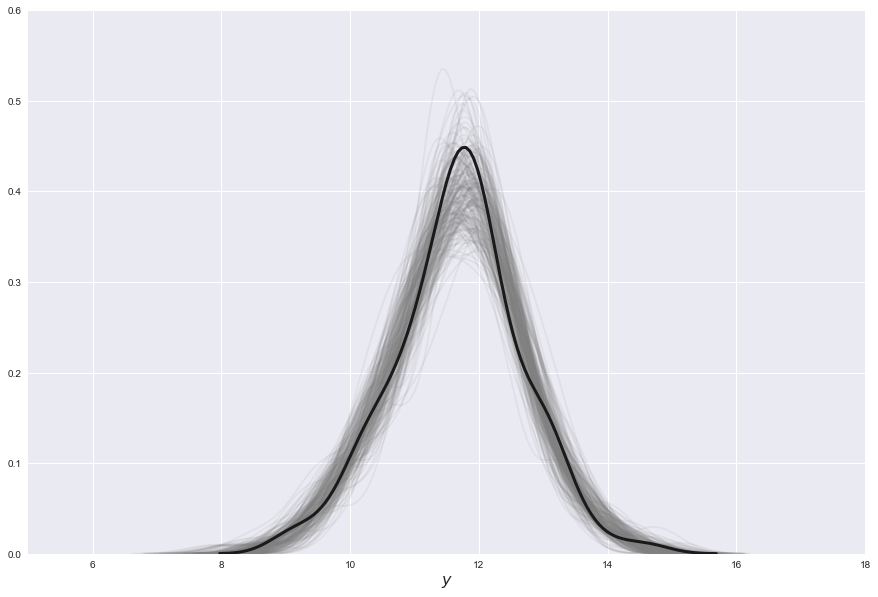

In [22]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);
plt.xlim((5,18))
plt.ylim((0,0.6))

## Interpreting posterior

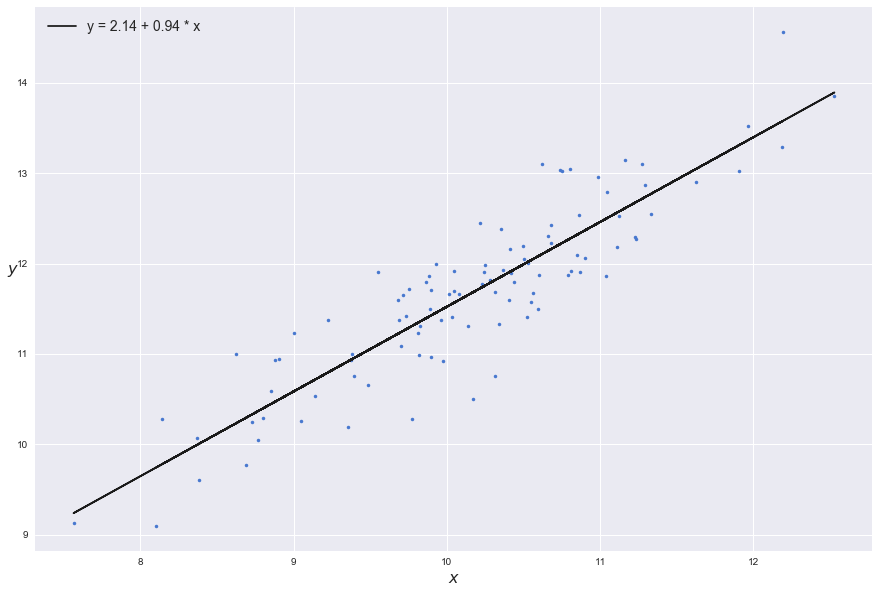

In [23]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

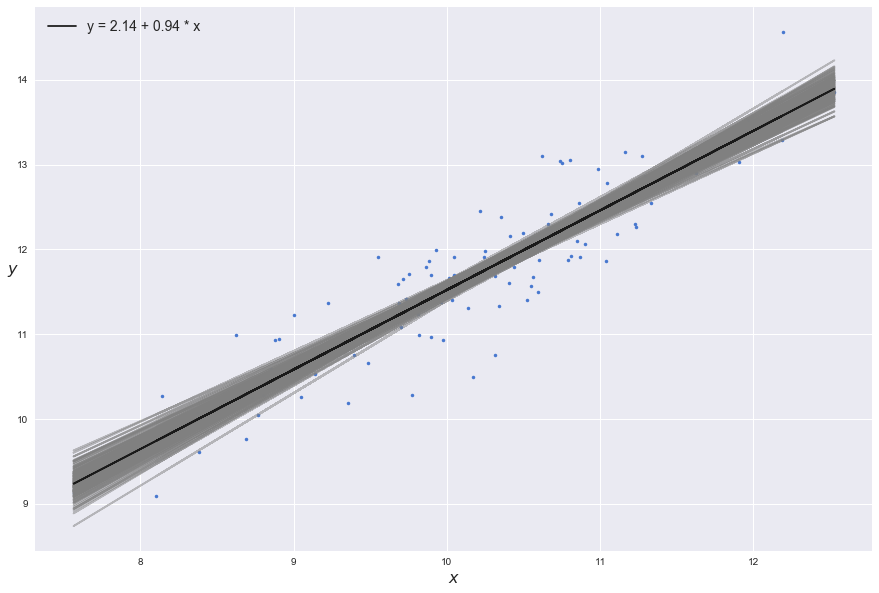

In [24]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace_n['alpha']), 10)
# add 200 transparent lines for every x value
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

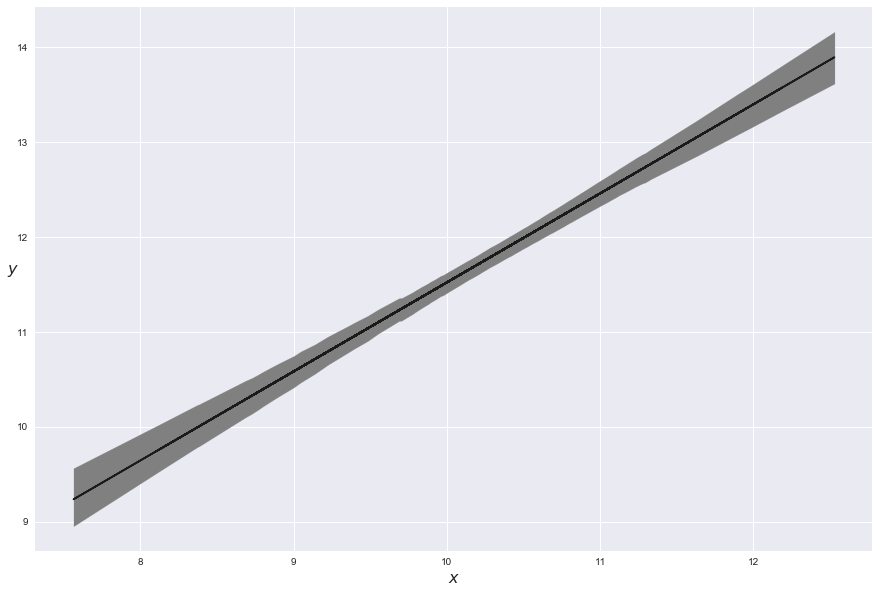

In [25]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

# return indexis that will sort array
idx = np.argsort(x)
x_ord = x[idx]
# main reason why mu was added as deterministic variable in model. 
# it can now be directly referenced in the trace as "mu"
# 98% HPD for mu
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

## HPD (highest posterior density) for predicted data (95% and 50%)

In [26]:
# getting posterior predictive samples
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.89it/s]


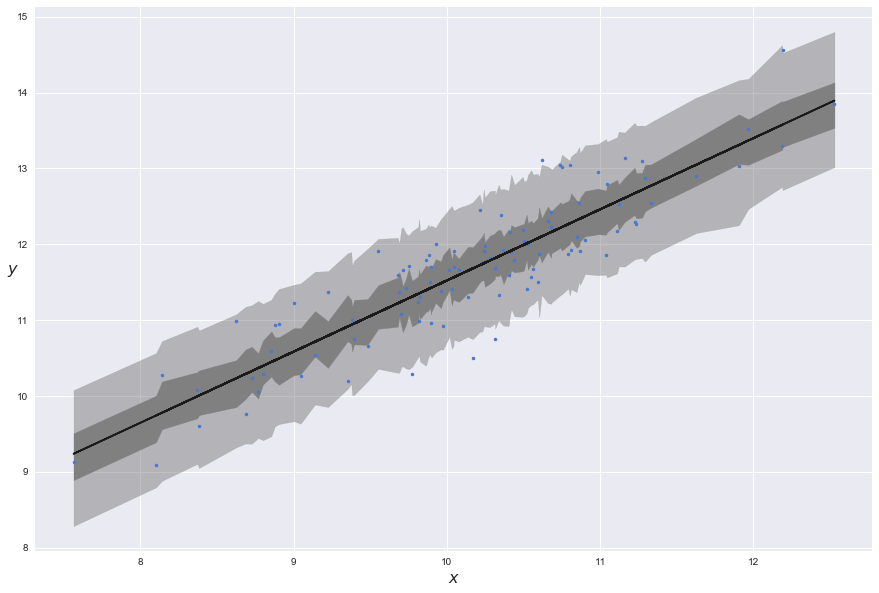

In [27]:
# add data points
plt.plot(x, y, 'b.')
# add the average line
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

# 50 % HPD
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
# 95% HPD
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

# Pearson correlation coefficient (r)

In [28]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    # r squared related to Pearson coefficient and slope
    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    # measure of dispersion between fitted line and mean of data
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    # proportional to variance of predicted variable.
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    # r squared determined similarly to least squares.
    rss = pm.Deterministic('rss', ss_reg/ss_tot)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 67.459650
         Iterations: 15
         Function evaluations: 26
         Gradient evaluations: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.22it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002389C50C240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238A0623978>]], dtype=object)

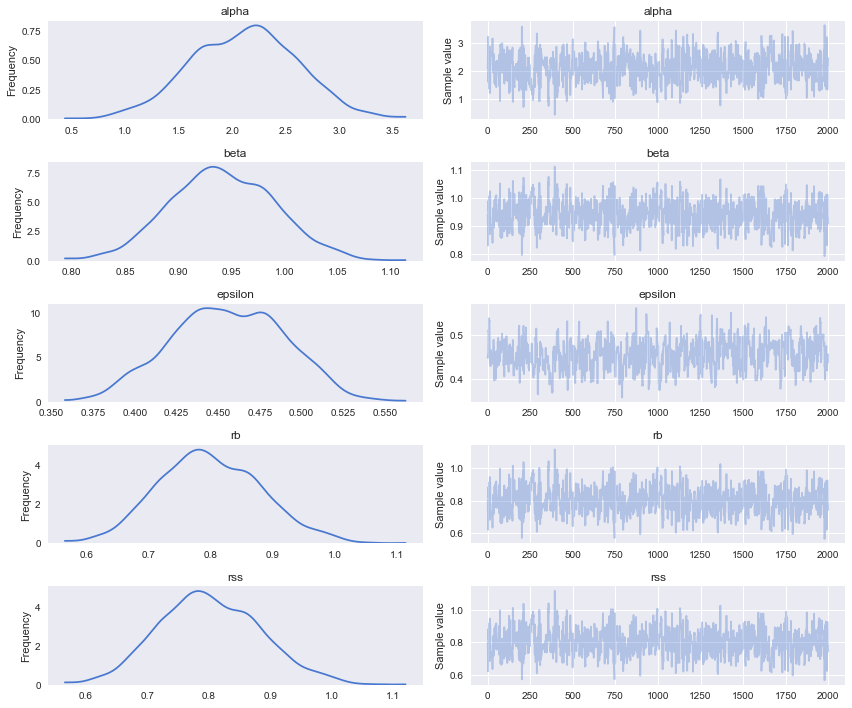

In [29]:
pm.traceplot(trace_n)

In [30]:
pm.df_summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.11,0.49,2.10e-02,1.15,3.06
beta,0.94,0.05,2.06e-03,0.85,1.04
epsilon,0.46,0.03,1.87e-03,0.39,0.52
rb,0.80,0.08,3.51e-03,0.65,0.96
rss,0.80,0.08,3.51e-03,0.65,0.97


## The multivariate normal distribution

### Contour plots for bivariate Gaussian distributions

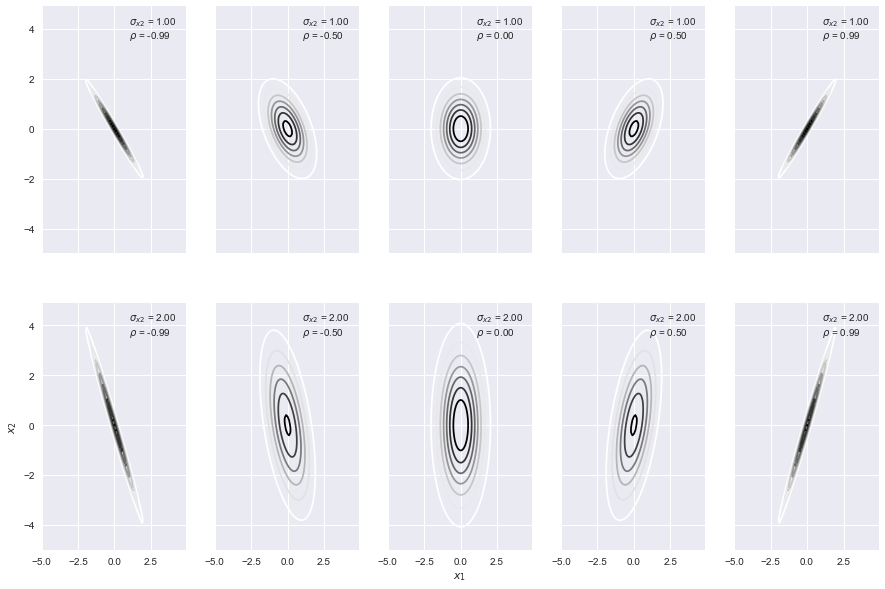

In [31]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        # bivariate Gaussian with both means zero
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')


In [32]:
data = np.stack((x, y)).T

In [33]:
with pm.Model() as pearson_model:
    
    # prior for means
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    # prior for sigma1
    sigma_1 = pm.HalfNormal('simga_1', 10)
    
    # prior for sigma2
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    
    # prior for pearson coefficient
    rho = pm.Uniform('rho', -1, 1)
    
    # manually building the covariance matrix
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_p = pm.sample(1000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 209.396958
         Iterations: 16
         Function evaluations: 25
         Gradient evaluations: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238A105EBA8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238AF2EC2B0>]], dtype=object)

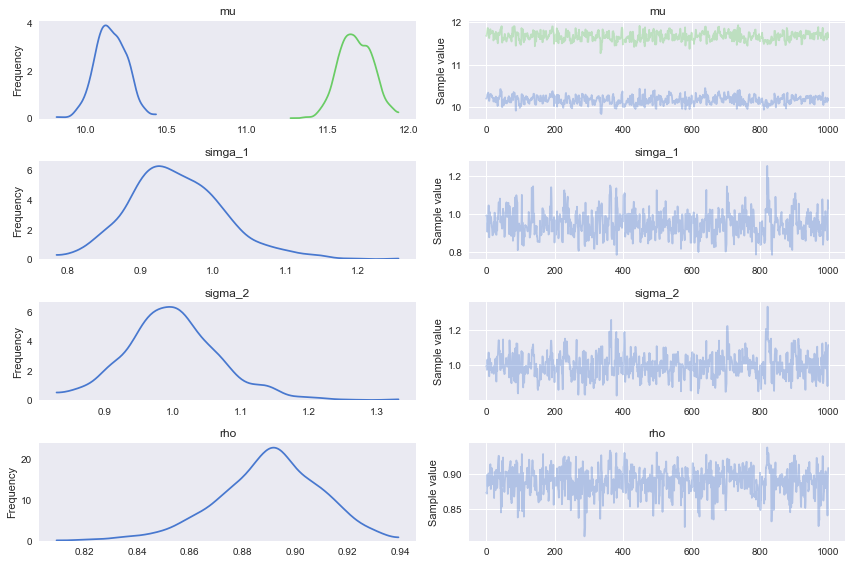

In [34]:
pm.traceplot(trace_p)

In [35]:
pm.df_summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu__0,10.16,0.10,5.33e-03,9.98,10.35
mu__1,11.67,0.10,5.79e-03,11.48,11.87
simga_1,0.95,0.07,3.33e-03,0.83,1.09
sigma_2,1.00,0.07,3.48e-03,0.88,1.15
rho,0.89,0.02,8.26e-04,0.85,0.93


# Robust Linear Regression

In [36]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


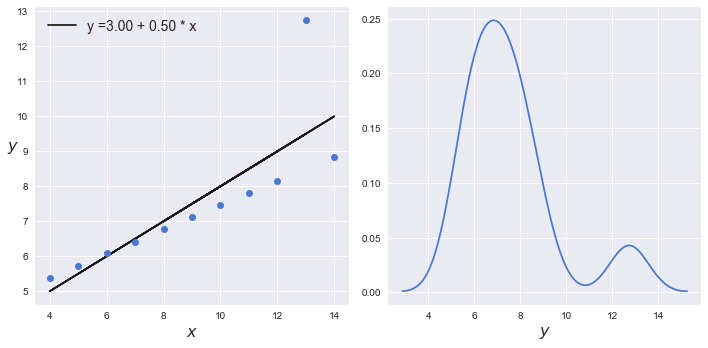

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()


In [38]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    # shifted exponential to avoid values of nu close to zero.
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(2000, step=step, start=start)

         Current function value: -11.957256
         Iterations: 42
         Function evaluations: 163
         Gradient evaluations: 150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 167.25it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238B4DF47B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238B40B6898>]], dtype=object)

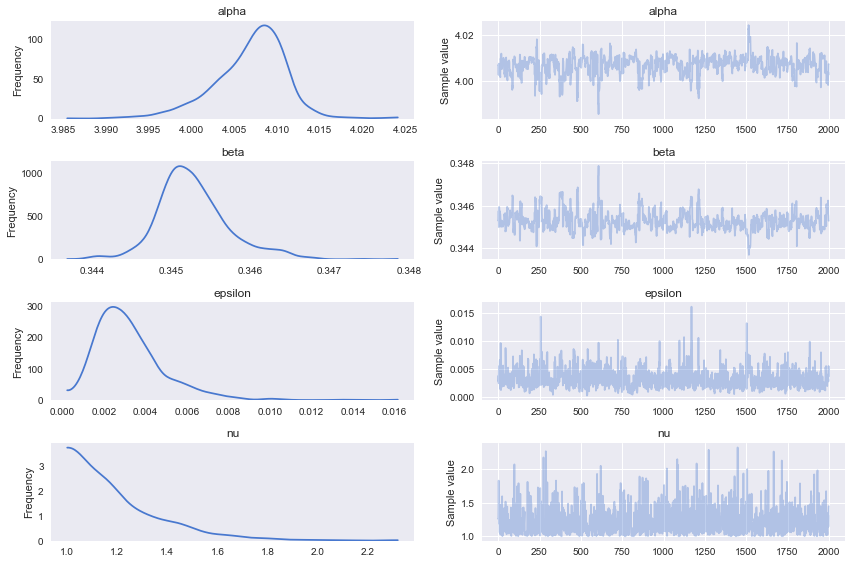

In [39]:
pm.traceplot(trace_t)

In [40]:
pm.df_summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.01e+00,4.15e-03,2.58e-04,4.00e+00,4.01e+00
beta,3.45e-01,4.50e-04,2.83e-05,3.45e-01,3.46e-01
epsilon,3.21e-03,1.66e-03,6.85e-05,6.38e-04,6.54e-03
nu,1.21e+00,1.96e-01,4.80e-03,1.00e+00,1.60e+00


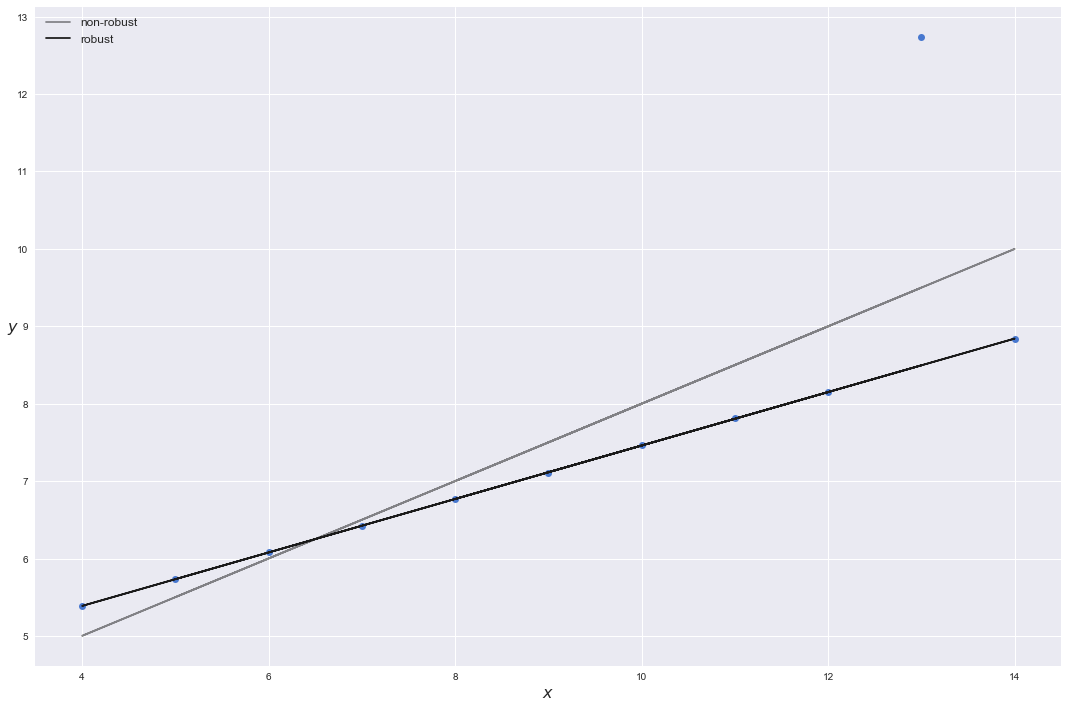

In [41]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

## Posterior Predictive Check

In [42]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 115.38it/s]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2641: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


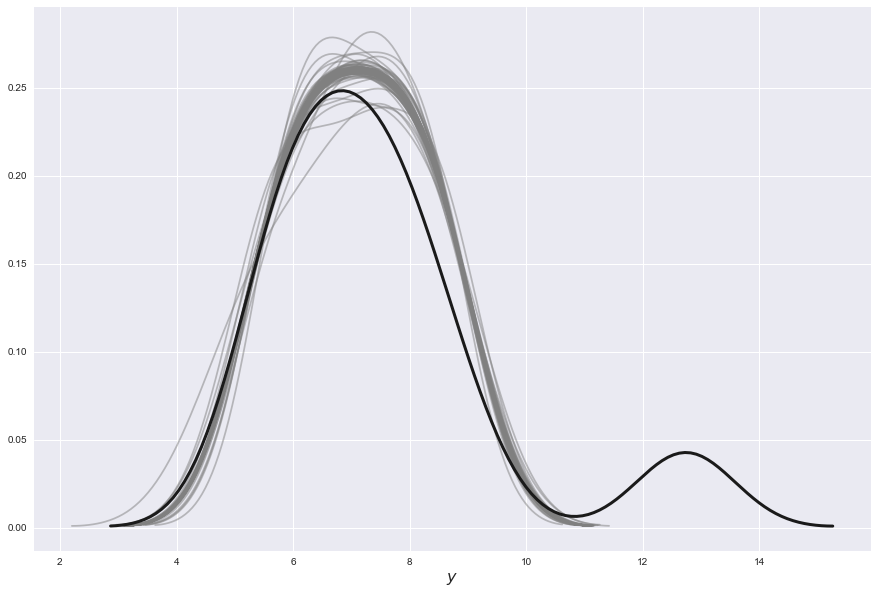

In [43]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


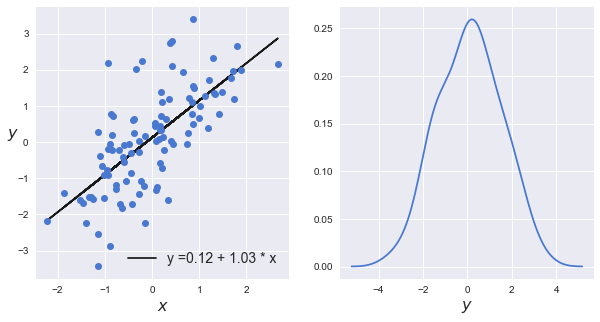

In [44]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=10, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)

In [45]:
with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    #nu = pm.Gamma('nu', mu=20, sd=15)
    #nu = pm.Gamma('nu', 2, 0.1)

    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=epsilon, nu=nu, observed=y_4)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t2 = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 151.219653
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 192.70it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238BB276F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238BB4835F8>]], dtype=object)

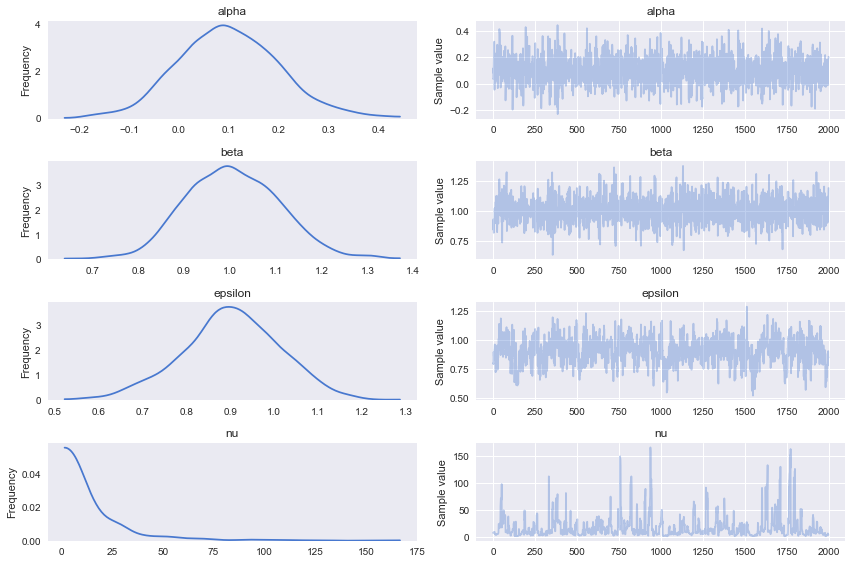

In [46]:
pm.traceplot(trace_t2)

In [47]:
pm.df_summary(trace_t2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.10,0.10,2.34e-03,-0.10,0.30
beta,1.01,0.10,2.49e-03,0.82,1.21
epsilon,0.90,0.11,5.95e-03,0.68,1.12
nu,18.69,21.92,1.34e+00,1.78,61.54


# Hierarchical linear regression

In [48]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

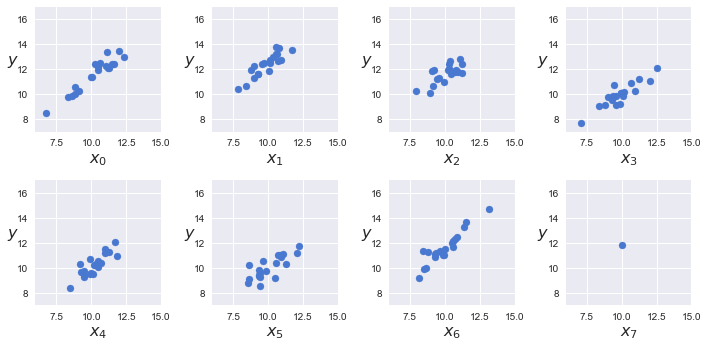

In [49]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [50]:
# center the data
x_centered = x_m - x_m.mean()

In [51]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 147.870276
         Iterations: 41
         Function evaluations: 54
         Gradient evaluations: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 337.19it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238B9C54F28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238BE43E860>]], dtype=object)

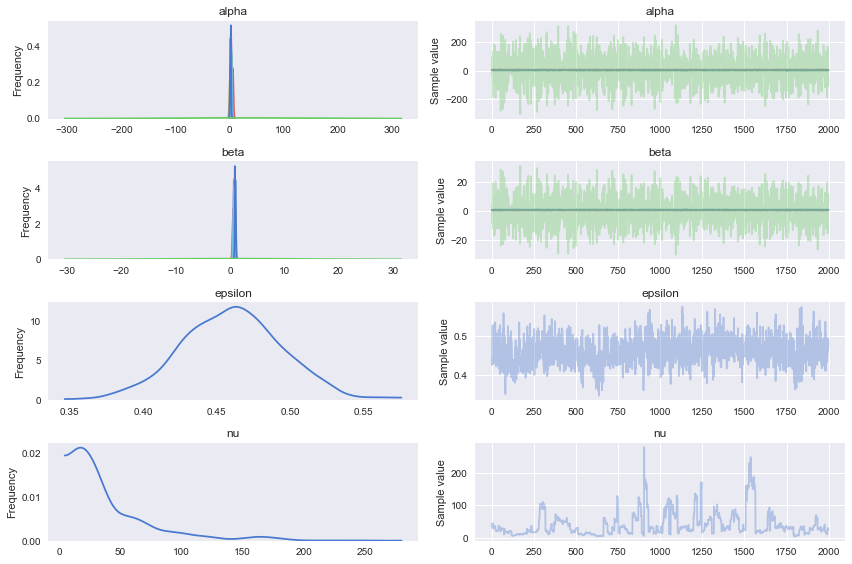

In [52]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)

In [53]:
pm.df_summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.43,0.78,1.47e-02,0.84,3.89
alpha__1,3.72,1.14,2.29e-02,1.47,5.97
alpha__2,5.65,1.30,2.63e-02,3.11,7.99
alpha__3,3.07,0.88,1.74e-02,1.29,4.68
alpha__4,1.25,1.36,2.69e-02,-1.21,3.94
alpha__5,3.22,1.03,2.42e-02,1.16,5.24
alpha__6,1.75,0.90,1.90e-02,0.08,3.52
alpha__7,9.37,102.26,1.85e+00,-201.43,196.42
beta__0,0.89,0.08,1.42e-03,0.75,1.04
beta__1,0.88,0.12,2.30e-03,0.65,1.11


In [54]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)
    
    # transform paramters back to original uncenterd scale
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

Average ELBO = -135.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6305.02it/s]
Finished [100%]: Average ELBO = -136
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.81it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238BA473748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238B6368FD0>]], dtype=object)

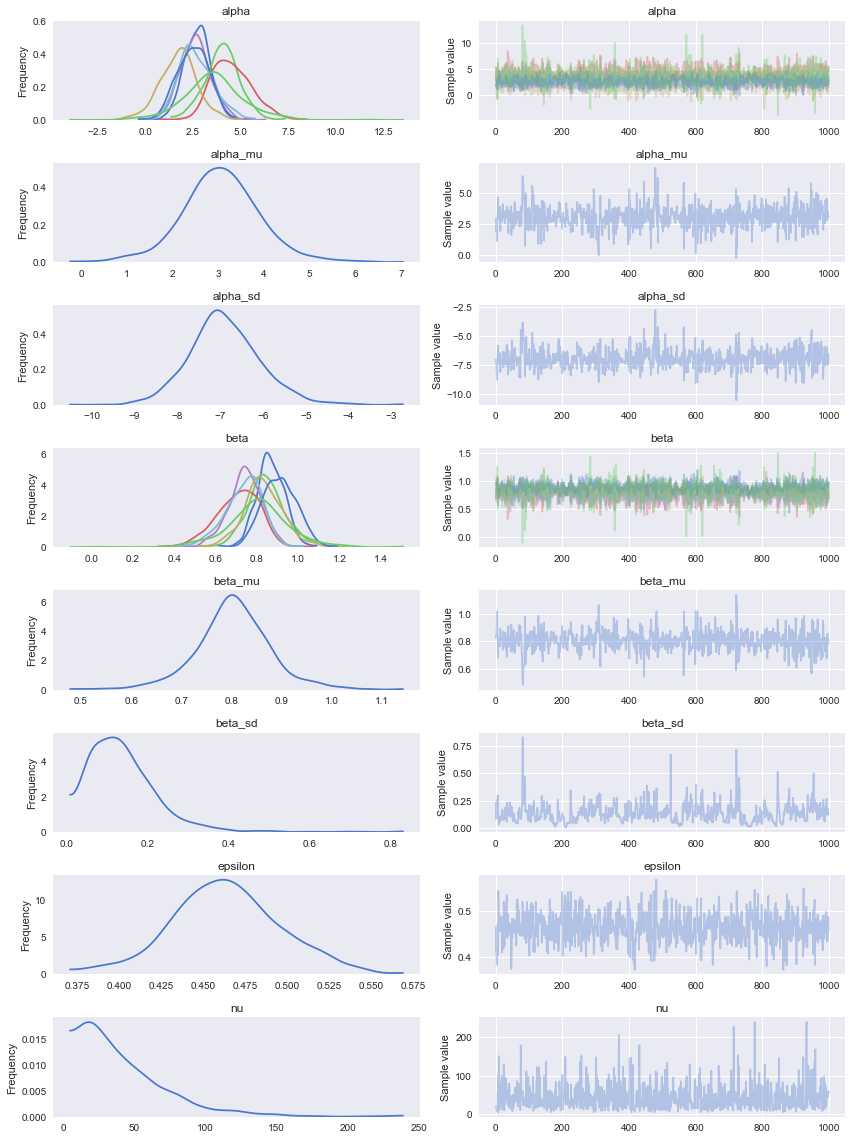

In [55]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)

In [56]:
pm.df_summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.72,0.69,3.01e-02,1.38,3.98
alpha__1,4.03,0.91,3.04e-02,2.15,5.73
alpha__2,4.52,1.07,4.59e-02,2.73,6.76
alpha__3,2.63,0.80,2.88e-02,1.04,4.21
alpha__4,1.72,0.99,3.09e-02,-0.17,3.85
alpha__5,2.65,0.92,3.34e-02,0.98,4.58
alpha__6,2.50,0.82,3.79e-02,0.84,3.95
alpha__7,3.60,1.71,7.46e-02,0.45,7.31
alpha_mu,3.06,0.88,3.88e-02,0.88,4.55
alpha_sd,-6.89,0.83,3.56e-02,-8.39,-5.18


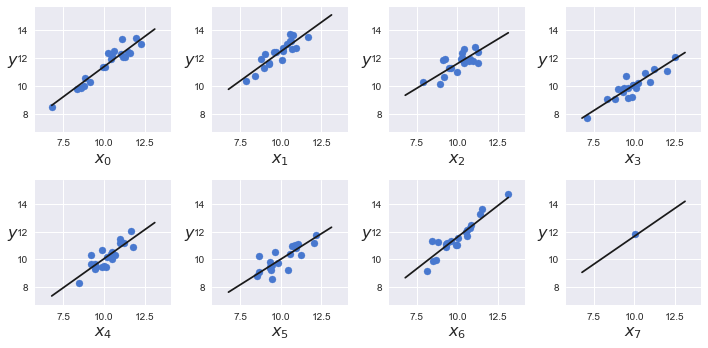

In [59]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()